In [37]:
using LinearAlgebra
using StaticArrays
using Interpolations

In [38]:
using Plots

In [39]:
using Revise

In [40]:
using ScientificRT

In [41]:
ScientificRT.greet()

Hello, world!

# Experiment with `test2.raw` (Perlin noise data)

In [42]:
# Number of voxels in X, Y, Z directions
const num_x_voxels = 100;
const num_y_voxels = 100;
const num_z_voxels = 100;

ℹ️ Here we are assuming cell-centered data. We sample onto a dual grid where the cell centers act as the vertices. Therefore, the number of intervals on each dimension is the number of voxels minus 1.

In [43]:
N_x = num_x_voxels - 1 # number of x intervals
N_y = num_y_voxels - 1 # number of y intervals
N_z = num_z_voxels - 1 # number of z intervals

99

In [44]:
interval_width = (domain_len, num_intervals) -> domain_len/num_intervals

#15 (generic function with 1 method)

## Read in the data

Read the data from binary file as an array of floats (code snippet from [StackOverflow post by "chunjiw"](https://stackoverflow.com/users/4966531/chunjiw))

In [45]:
io = open("../../data/perlin_noise/test2_alt.raw", "r")
raw_data = Array{Float32, 1}(undef, num_x_voxels*num_y_voxels*num_z_voxels);
read!(io, raw_data);

In [46]:
volume = reshape(raw_data,num_x_voxels,num_y_voxels,num_z_voxels);

┌ Info: Saved animation to 
│   fn = /home/nathan/Code/scientific-ray-tracing/volume_raymarching/julia/tmp.gif
└ @ Plots /home/nathan/.julia/packages/Plots/EJmJT/src/animation.jl:102


Plots.AnimatedGif("/home/nathan/Code/scientific-ray-tracing/volume_raymarching/julia/tmp.gif")
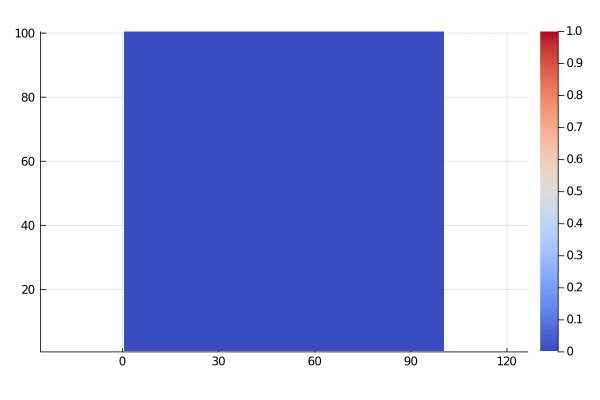

In [47]:
@gif for i ∈ 1:N_x
    heatmap(volume[:,i,:], aspect_ratio=:equal, seriescolor=:coolwarm, clims=(0.,1.))
end

┌ Info: Saved animation to 
│   fn = /home/nathan/Code/scientific-ray-tracing/volume_raymarching/julia/tmp.gif
└ @ Plots /home/nathan/.julia/packages/Plots/EJmJT/src/animation.jl:102


Plots.AnimatedGif("/home/nathan/Code/scientific-ray-tracing/volume_raymarching/julia/tmp.gif")
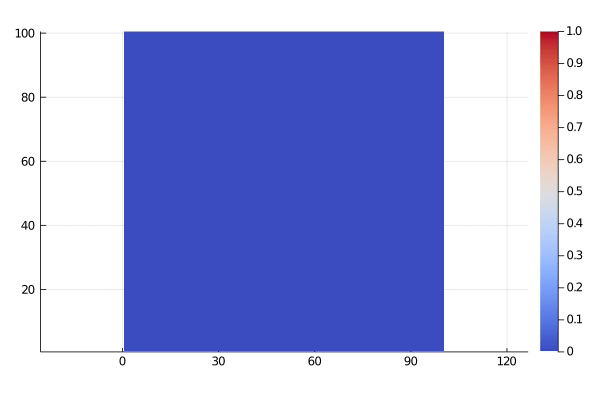

In [48]:
@gif for j ∈ 1:N_y
    heatmap(volume[j,:,:], aspect_ratio=:equal, seriescolor=:coolwarm, clims=(0.,1.))
end

┌ Info: Saved animation to 
│   fn = /home/nathan/Code/scientific-ray-tracing/volume_raymarching/julia/tmp.gif
└ @ Plots /home/nathan/.julia/packages/Plots/EJmJT/src/animation.jl:102


Plots.AnimatedGif("/home/nathan/Code/scientific-ray-tracing/volume_raymarching/julia/tmp.gif")
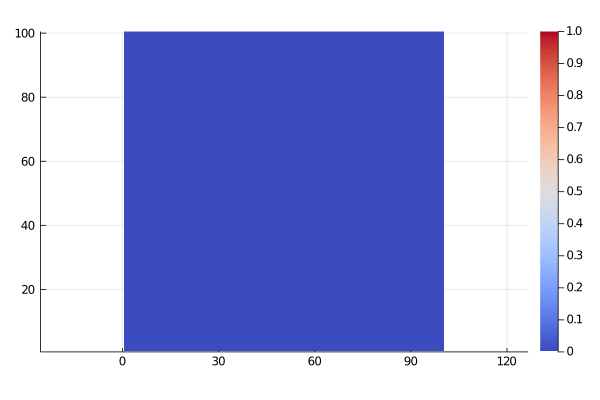

In [49]:
@gif for k ∈ 1:N_z
    heatmap(volume[:,:,k], aspect_ratio=:equal, seriescolor=:coolwarm, clims=(0.,1.))
end

## Set up linear interpolation for the volume

ℹ️ Assumption: Corners of volume are from (-0.5,-0.5,-0.5) to (0.5,0.5,0.5)

In [50]:
const x_len = 1.0
const y_len = 1.0
const z_len = 1.0

const x_step = interval_width(x_len,N_x)
const y_step = interval_width(y_len,N_y)
const z_step = interval_width(z_len,N_z)

const xs = -0.5:x_step:0.5
const ys = -0.5:y_step:0.5
const zs = -0.5:z_step:0.5

vol_trilinear = LinearInterpolation((xs, ys, zs), volume);

## Test sampling point in volume (compare to heatmap)

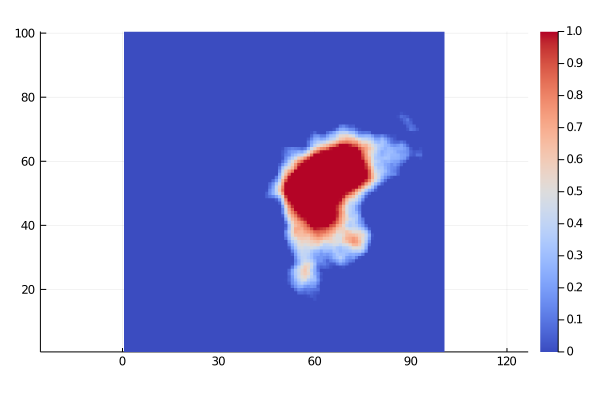

In [51]:
heatmap(volume[:,:,50], aspect_ratio=:equal, seriescolor=:coolwarm, clims=(0.,1.))

In [52]:
# Horiziontal line thru y=0.5
horiz_line_values = [vol_trilinear(0.0,x,0.0) for x in -0.5:0.01:0.5];

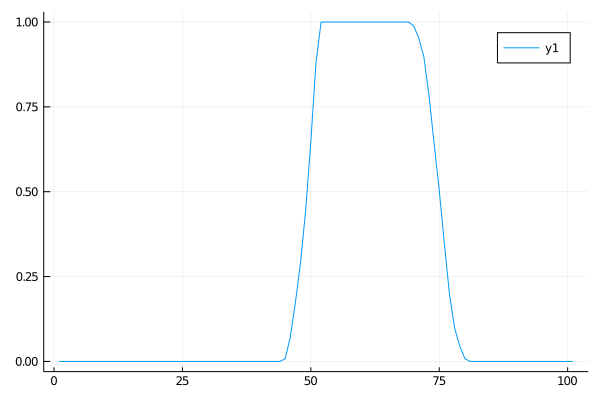

In [53]:
plot(horiz_line_values)

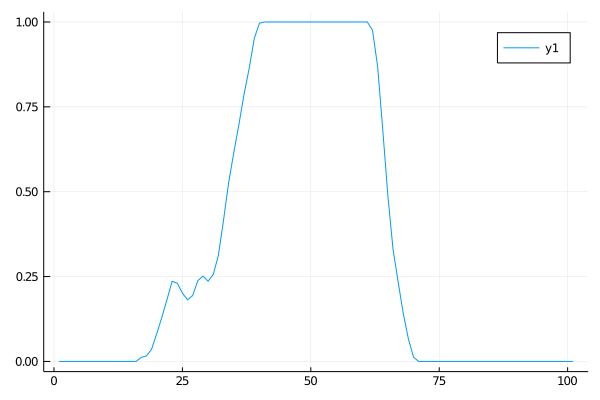

In [54]:
# Vertical line thru x=0.6
vert_line_values = [vol_trilinear(y,0.1,0.0) for y in -0.5:0.01:0.5];
plot(vert_line_values)

## Test sampling along a ray

### Test evaluating the ray at different values of `t`

In [55]:
foo = Ray(SA[1.0;2.0;3.0],SA[1.0;1.0;1.0])

Ray{SArray{Tuple{3},Float64,1,3}}([1.0, 2.0, 3.0], [1.0, 1.0, 1.0])

In [56]:
foo(0)

3-element SArray{Tuple{3},Float64,1,3} with indices SOneTo(3):
 1.0
 2.0
 3.0

In [57]:
foo(0.5)

3-element SArray{Tuple{3},Float64,1,3} with indices SOneTo(3):
 1.5
 2.5
 3.5

### Test sampling through the volume

In [58]:
# "probe" that sweeps diagonally through the volume, goes from -0.5,-0.5,-0.5 to 1,1,1
probeRay = Ray([-0.5;-0.5;-0.5],normalize([1.0;1.0;1.0]))

Ray{Array{Float64,1}}([-0.5, -0.5, -0.5], [0.5773502691896258, 0.5773502691896258, 0.5773502691896258])

In [59]:
const probe_resolution = 1000
const probe_start_t = 0.0
const probe_end_t = sqrt(3) # because we are traversing the diagonal of a cube
const probe_step = (probe_end_t - probe_start_t)/probe_resolution

0.0017320508075688772

In [60]:
# points on the ray to sample the volume at
probeLine = [probeRay(t) for t in probe_start_t:probe_step:probe_end_t]; 

In [61]:
probeRay(probe_end_t)

3-element Array{Float64,1}:
 0.5
 0.5
 0.5

In [62]:
probeResults = [vol_trilinear(x,y,z) for (x, y, z) in probeLine];

In [75]:
vol_trilinear(0,0,0)

0.8792536109685879

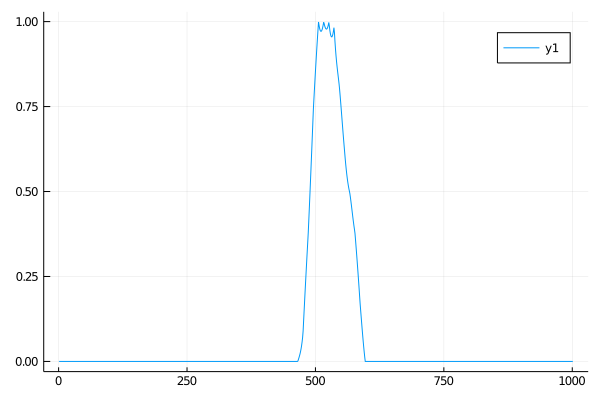

In [63]:
plot(probeResults)

### Test sampling the volume, using a slightly different method

In [64]:
function sample_vol_with_ray(ray, t)
    pos = ray(t)
    return vol_trilinear(pos[1],pos[2],pos[3])
end

sample_vol_with_ray (generic function with 1 method)

In [65]:
probeResults_alt = [sample_vol_with_ray(probeRay, t) for t in 
        probe_start_t:probe_step:probe_end_t]; 

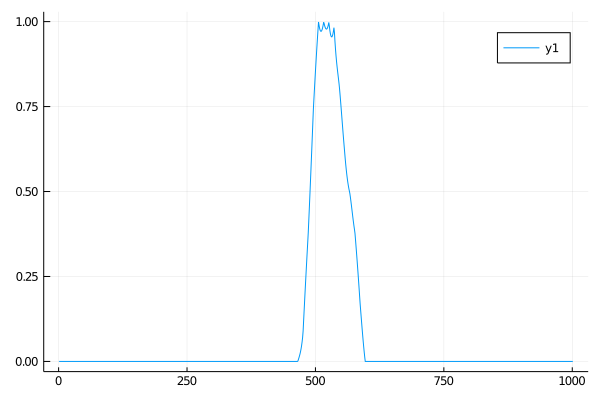

In [66]:
plot(probeResults_alt)

### Test sampling transmittance through the volume

In [67]:
σ_t = λ -> sample_vol_with_ray(probeRay, λ)

#25 (generic function with 1 method)

In [68]:
σ_t_max = 1;
tstart = probe_start_t;
tmax = probe_end_t;

In [69]:
σ_sampler = sampler_factory(tstart, σ_t, σ_t_max, dist_until_interact);

In [70]:
t_range = probe_start_t:probe_step:probe_end_t
approx_transmittances = est_transmittance.(σ_sampler, t_range, 1000);

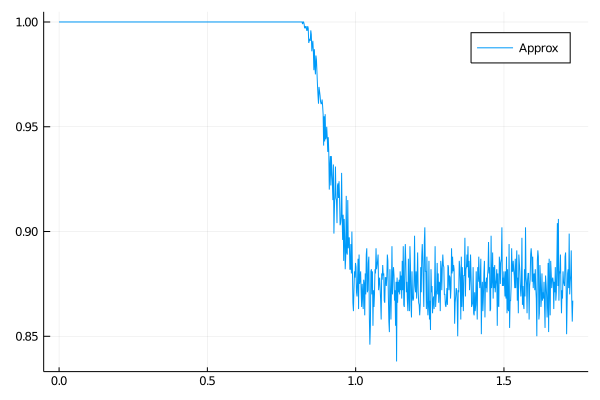

In [71]:
plot(t_range, approx_transmittances, label="Approx")

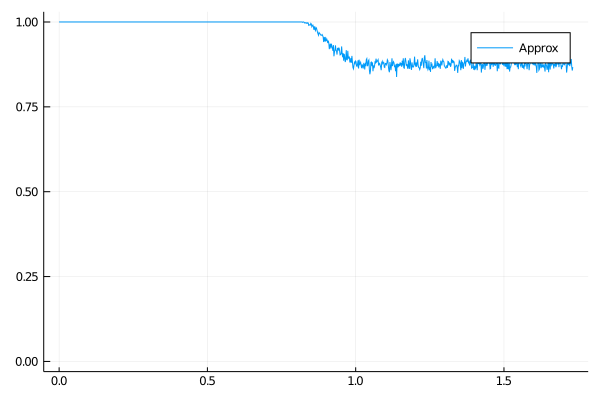

In [72]:
plot(t_range, approx_transmittances, label="Approx", ylims=[0,1])